Epoch 1/20 => Train Loss: 35.0105, Test Loss: 31.3576
Epoch 2/20 => Train Loss: 33.3939, Test Loss: 31.1013
Epoch 3/20 => Train Loss: 31.8349, Test Loss: 30.8613
Epoch 4/20 => Train Loss: 30.3329, Test Loss: 30.6339
Epoch 5/20 => Train Loss: 28.8871, Test Loss: 30.4161
Epoch 6/20 => Train Loss: 27.4964, Test Loss: 30.2072
Epoch 7/20 => Train Loss: 26.1596, Test Loss: 30.0069
Epoch 8/20 => Train Loss: 24.8755, Test Loss: 29.8149
Epoch 9/20 => Train Loss: 23.6429, Test Loss: 29.6306
Epoch 10/20 => Train Loss: 22.4604, Test Loss: 29.4531
Epoch 11/20 => Train Loss: 21.3266, Test Loss: 29.2818
Epoch 12/20 => Train Loss: 20.2401, Test Loss: 29.1164
Epoch 13/20 => Train Loss: 19.1995, Test Loss: 28.9568
Epoch 14/20 => Train Loss: 18.2034, Test Loss: 28.8032
Epoch 15/20 => Train Loss: 17.2504, Test Loss: 28.6560
Epoch 16/20 => Train Loss: 16.3391, Test Loss: 28.5154
Epoch 17/20 => Train Loss: 15.4684, Test Loss: 28.3817
Epoch 18/20 => Train Loss: 14.6367, Test Loss: 28.2554
Epoch 19/20 => Trai

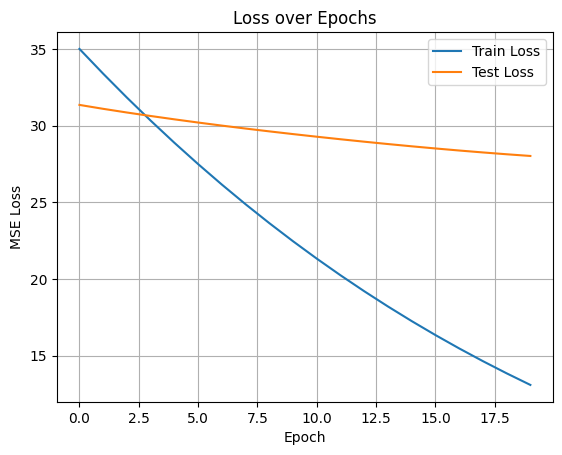

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Create mock data
def create_mock_data(num_users=50, num_products=30):
    np.random.seed(42)
    user_ids = [f'user_{i}' for i in range(1, num_users + 1)]
    product_ids = [f'product_{j}' for j in range(1, num_products + 1)]
    
    data = []
    for user_idx, user in enumerate(user_ids):
        rated_products = np.random.choice(product_ids, size=np.random.randint(1, 10), replace=False)
        for product in rated_products:
            rating = np.random.randint(1, 6)
            product_idx = product_ids.index(product)
            data.append((user_idx, product_idx, rating))
    
    df = pd.DataFrame(data, columns=['user_id', 'product_id', 'rating'])
    return df, len(user_ids), len(product_ids)

# 2. Build matrix factorization model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=20):
        super(MatrixFactorization, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_size)
        self.item_embed = nn.Embedding(num_items, embedding_size)

    def forward(self, user, item):
        return (self.user_embed(user) * self.item_embed(item)).sum(1)

# 3. Training function
def train_model(df, num_users, num_items, epochs=20, lr=0.01):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    model = MatrixFactorization(num_users, num_items)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_users = torch.LongTensor(train_df['user_id'].values)
    train_items = torch.LongTensor(train_df['product_id'].values)
    train_ratings = torch.FloatTensor(train_df['rating'].values)

    test_users = torch.LongTensor(test_df['user_id'].values)
    test_items = torch.LongTensor(test_df['product_id'].values)
    test_ratings = torch.FloatTensor(test_df['rating'].values)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(train_users, train_items)
        loss = criterion(preds, train_ratings)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_preds = model(test_users, test_items)
            test_loss = criterion(test_preds, test_ratings)
            test_losses.append(test_loss.item())

        print(f"Epoch {epoch+1}/{epochs} => Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    return model, train_losses, test_losses

# 4. Plotting
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run everything
df, num_users, num_products = create_mock_data()
model, train_losses, test_losses = train_model(df, num_users, num_products)
plot_losses(train_losses, test_losses)


In [32]:
def get_recommendations(model, df, user_id, num_recommendations=5):
    # Get all products and find unrated ones
    all_product_ids = df['product_id'].unique()
    rated_products = df[df['user_id'] == user_id]['product_id'].values
    unrated_products = [pid for pid in all_product_ids if pid not in rated_products]
    
    # Create tensor for user and unrated products
    user_tensor = torch.LongTensor([user_id] * len(unrated_products))
    product_tensor = torch.LongTensor(unrated_products)

    # Predict ratings for unrated products
    model.eval()
    with torch.no_grad():
        predicted_ratings = model(user_tensor, product_tensor)
    
    # Get top N recommendations
    recommended_indices = predicted_ratings.argsort(descending=True)[:num_recommendations]

    # Get the recommended products and their predicted ratings
    recommended_products = [unrated_products[i] for i in recommended_indices]
    predicted_ratings = predicted_ratings - predicted_ratings.min()
    recommended_ratings = predicted_ratings[recommended_indices].tolist()

    return recommended_products, recommended_ratings

# Get recommendations for a specific user (e.g., user_id = 1)


In [33]:
# Get recommendations for a specific user (e.g., user_id = 0)
recommended_products, predicted_ratings = get_recommendations(model, df, user_id=1, num_recommendations=40)
print("Recommended products for user 1:")
for product, rating in zip(recommended_products, predicted_ratings):
    print(f"Product ID: {product}, Predicted Rating: {rating:.2f}")

Recommended products for user 1:
Product ID: 1, Predicted Rating: 18.81
Product ID: 10, Predicted Rating: 18.73
Product ID: 2, Predicted Rating: 16.19
Product ID: 21, Predicted Rating: 12.96
Product ID: 11, Predicted Rating: 10.40
Product ID: 12, Predicted Rating: 9.58
Product ID: 0, Predicted Rating: 9.20
Product ID: 18, Predicted Rating: 9.09
Product ID: 17, Predicted Rating: 8.64
Product ID: 22, Predicted Rating: 8.30
Product ID: 14, Predicted Rating: 7.95
Product ID: 27, Predicted Rating: 7.41
Product ID: 20, Predicted Rating: 6.79
Product ID: 6, Predicted Rating: 6.38
Product ID: 5, Predicted Rating: 6.13
Product ID: 24, Predicted Rating: 5.94
Product ID: 28, Predicted Rating: 5.58
Product ID: 16, Predicted Rating: 5.58
Product ID: 19, Predicted Rating: 5.25
Product ID: 4, Predicted Rating: 4.74
Product ID: 23, Predicted Rating: 2.65
Product ID: 7, Predicted Rating: 2.42
Product ID: 25, Predicted Rating: 2.16
Product ID: 13, Predicted Rating: 2.00
Product ID: 9, Predicted Rating: 